In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import random
from collections import deque
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

# Configuration
TICKER = 'BTCUSDT'
SEQ_LENGTH = 60
PREDICTION_STEPS = 10
INITIAL_BALANCE = 10000.0
TRADE_FEE_RATE = 0.0001
MIN_TRADE_AMOUNT = 1
GRID_COUNT = 20
EPOCHS = 500
EPISODES = 100
BATCH_SIZE = 256
MEMORY_SIZE = 10000
GAMMA = 0.95
EPSILON_DECAY = 0.995
MIN_EPSILON = 0
LEARNING_RATE = 0.0001
TARGET_UPDATE_FREQ = 100
LSTM_LEARNING_RATE = 100
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class DataProcessor:
    def __init__(self, filepath):
        self.data = pd.read_csv(filepath)
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        
    def preprocess(self):
        df = self.data.copy()
        # Feature engineering
        df['Returns'] = df['close'].pct_change()
        df['Volatility'] = df['Returns'].rolling(20).std()
        df.dropna(inplace=True)
        
        # Scale features
        scaled = self.scaler.fit_transform(df[['open', 'high', 'low', 'close', 'volume', 'Returns', 'Volatility']])
        return scaled, df['close'].values
    
    def create_sequences(self, data, target):
        X, y = [], []
        for i in range(len(data) - SEQ_LENGTH - PREDICTION_STEPS):
            X.append(data[i:i+SEQ_LENGTH])
            y.append(target[i+SEQ_LENGTH+PREDICTION_STEPS-1])
        return np.array(X), np.array(y)

class LSTMPredictor(nn.Module):
    def __init__(self, input_size, hidden_size=50, num_layers=2):
        super(LSTMPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_size)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class DuelingDQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DuelingDQN, self).__init__()
        self.feature = nn.Sequential(
            nn.Linear(state_size, 128),
            nn.ReLU()
        )

        self.value_stream = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

        self.advantage_stream = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_size)
        )

    def forward(self, x):
        x = self.feature(x)
        value = self.value_stream(x)
        advantage = self.advantage_stream(x)
        q_values = value + advantage - advantage.mean(dim=1, keepdim=True)
        return q_values

class TradingEnvironment:
    def __init__(self, data, prices, predictor, grids):
        self.data = data
        self.prices = prices
        self.predictor = predictor
        self.grids = grids
        self.reset()
        
    def reset(self):
        self.current_step = SEQ_LENGTH
        self.balance = INITIAL_BALANCE
        self.btc_held = 0.0
        self.portfolio_value = [INITIAL_BALANCE]
        self.trades = []
        self.done = False
        self.prev_portfolio_value = INITIAL_BALANCE   # <-- Add this line
        return self.get_state()

    
    def get_state(self):
        current_data = self.data[self.current_step]
        price = self.prices[self.current_step]
        grid_position = np.digitize(price, self.grids) / GRID_COUNT
        
        # Get prediction
        with torch.no_grad():
            seq_data = self.data[self.current_step-SEQ_LENGTH:self.current_step]
            seq_tensor = torch.tensor(seq_data[np.newaxis, ...], dtype=torch.float32).to(device)
            prediction = self.predictor(seq_tensor).cpu().item()
        
        return np.array([
            *current_data,
            self.balance / INITIAL_BALANCE,
            self.btc_held * price / INITIAL_BALANCE,
            grid_position,
            prediction / price
        ])
    
    def execute_trade(self, action, amount):
        fee = amount * TRADE_FEE_RATE
        return amount - fee
    
    def step(self, action):
        """
        Actions:
        0 = hold
        1 = buy
        2 = sell
        """
        price = self.prices[self.current_step]
        grid_position = np.digitize(price, self.grids) / len(self.grids)  # normalized 0-1
        
        trade_amount = 0
        min_trade_usd = 10  # Minimum USD amount per trade, for example
        min_trade_btc = 0.001  # Minimum BTC amount per trade
        
        if action == 1:  # Buy
            # Buy more when price is near lower grids (grid_position close to 0)
            multiplier = max(0.1, 1 - grid_position)  # from 1 at bottom grid to 0.1 near top grid
            amount_to_spend = self.balance * multiplier
            trade_amount = max(amount_to_spend, min_trade_usd)
            
            btc_to_buy = trade_amount / price
            btc_to_buy = min(btc_to_buy, self.balance / price)  # Can't buy more than balance allows
            btc_to_buy = max(btc_to_buy, min_trade_btc)
            
            # Execute buy
            cost = btc_to_buy * price
            if cost <= self.balance:
                self.balance -= cost
                self.btc_held += btc_to_buy
                self.trades.append(('buy', price, self.current_step))
        
        elif action == 2:  # Sell
            # Sell more when price is near upper grids (grid_position close to 1)
            multiplier = max(0.1, grid_position)  # from 0.1 at bottom grid to 1 near top grid
            btc_to_sell = self.btc_held * multiplier
            btc_to_sell = max(btc_to_sell, min_trade_btc)
            
            # Execute sell
            if btc_to_sell <= self.btc_held:
                revenue = btc_to_sell * price
                self.balance += revenue
                self.btc_held -= btc_to_sell
                self.trades.append(('sell', price, self.current_step))
        
        else:
            # Hold - no trade
            pass
        
        # Update portfolio value, rewards, etc.
        self.current_step += 1
        self.done = self.current_step >= len(self.prices) - 1
        
        portfolio_value = self.balance + self.btc_held * price
        reward = portfolio_value - self.prev_portfolio_value
        self.prev_portfolio_value = portfolio_value
        
        next_state = self.get_state()
        
        return next_state, reward, self.done, portfolio_value

class AdaptiveTradingEnvironment(TradingEnvironment):
    def __init__(self, data, prices, predictor, initial_grids, 
                 recalibration_interval=100, lookback_window=500):
        self.original_grids = initial_grids
        self.recalibration_interval = recalibration_interval
        self.lookback_window = lookback_window
        self.steps_since_recalibration = 0
        self.grid_history = [initial_grids.copy()]
        super().__init__(data, prices, predictor, initial_grids)
    def reset(self):
        self.steps_since_recalibration = 0
        self.grids = self.original_grids.copy()
        return super().reset()
    
    def recalculate_grids(self):
        """Recalculate grids based on recent price window"""
        start_idx = max(0, self.current_step - self.lookback_window)
        recent_prices = self.prices[start_idx:self.current_step]
        
        # Use percentiles to avoid extreme values
        low = np.percentile(recent_prices, 10)  # 10th percentile
        high = np.percentile(recent_prices, 90)  # 90th percentile
        
        # Safety checks
        if high <= low:
            high = low * 1.2  # Prevent invalid range
            
        new_grids = np.linspace(low, high, num=GRID_COUNT+1)[1:-1]
        self.grid_history.append(new_grids)
        return new_grids
    
    def step(self, action):
        # Recalculate grids periodically
        self.steps_since_recalibration += 1
        if self.steps_since_recalibration >= self.recalibration_interval:
            self.grids = self.recalculate_grids()
            self.steps_since_recalibration = 0
        
        return super().step(action)
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=MEMORY_SIZE)
        self.epsilon = 1
        self.model = DQN(state_size, action_size).to(device)
        self.target_model = DQN(state_size, action_size).to(device)
        self.target_model.load_state_dict(self.model.state_dict())
        self.target_model.eval()
        self.optimizer = optim.Adam(self.model.parameters(), lr=LEARNING_RATE)
        self.scheduler = StepLR(self.optimizer, step_size=50, gamma=0.95)
        self.criterion = nn.MSELoss()
        self.steps = 0
    
    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
            with torch.no_grad():
                q_values = self.model(state_tensor)
            return torch.argmax(q_values).item()
    
    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        
        minibatch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)
        
        states = torch.tensor(np.array(states), dtype=torch.float32).to(device)
        actions = torch.tensor(actions, dtype=torch.long).unsqueeze(1).to(device)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        next_states = torch.tensor(np.array(next_states), dtype=torch.float32).to(device)
        dones = torch.tensor(dones, dtype=torch.float32).to(device)
        
        # Get current Q values
        current_q = self.model(states).gather(1, actions)
        
        # Get target Q values
        with torch.no_grad():
            next_q = self.target_model(next_states).max(1)[0]
            target_q = rewards + (1 - dones) * GAMMA * next_q
        
        # Compute loss
        loss = self.criterion(current_q.squeeze(), target_q)
        
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.scheduler.step()
        # Update target network
        self.steps += 1
        if self.steps % TARGET_UPDATE_FREQ == 0:
            self.update_target_model()
        
        # Epsilon decay
        if self.epsilon > MIN_EPSILON:
            self.epsilon *= EPSILON_DECAY
    
    def save(self, path):
        torch.save(self.model.state_dict(), path)
    
    def load(self, path):
        self.model.load_state_dict(torch.load(path))
        
class DoubleDQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=MEMORY_SIZE)
        self.epsilon = 1
        self.model = DQN(state_size, action_size).to(device)
        self.target_model = DQN(state_size, action_size).to(device)
        self.target_model.load_state_dict(self.model.state_dict())
        self.target_model.eval()
        self.optimizer = optim.Adam(self.model.parameters(), lr=LEARNING_RATE)
        self.scheduler = StepLR(self.optimizer, step_size=5, gamma=0.95)
        self.criterion = nn.MSELoss()
        self.steps = 0
    
    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
            with torch.no_grad():
                q_values = self.model(state_tensor)
            return torch.argmax(q_values).item()
    
    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return

        minibatch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)

        states = torch.tensor(np.array(states), dtype=torch.float32).to(device)
        actions = torch.tensor(actions, dtype=torch.long).unsqueeze(1).to(device)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        next_states = torch.tensor(np.array(next_states), dtype=torch.float32).to(device)
        dones = torch.tensor(dones, dtype=torch.float32).to(device)

        # Q(s,a)
        current_q = self.model(states).gather(1, actions)

        # Double DQN target
        with torch.no_grad():
            # Select best action using online network
            best_actions = self.model(next_states).argmax(1, keepdim=True)
            # Evaluate using target network
            next_q = self.target_model(next_states).gather(1, best_actions)
            target_q = rewards.unsqueeze(1) + (1 - dones.unsqueeze(1)) * GAMMA * next_q

        loss = self.criterion(current_q, target_q)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.scheduler.step()

        self.steps += 1
        if self.steps % TARGET_UPDATE_FREQ == 0:
            self.update_target_model()

        if self.epsilon > MIN_EPSILON:
            self.epsilon *= EPSILON_DECAY

    
    def save(self, path):
        torch.save(self.model.state_dict(), path)
    
    def load(self, path):
        self.model.load_state_dict(torch.load(path))
class DuelDoubleDQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=MEMORY_SIZE)
        self.epsilon = 1
        self.model = DuelingDQN(state_size, action_size).to(device)
        self.target_model = DuelingDQN(state_size, action_size).to(device)
        self.target_model.load_state_dict(self.model.state_dict())
        self.target_model.eval()
        self.optimizer = optim.Adam(self.model.parameters(), lr=LEARNING_RATE)
        self.scheduler = StepLR(self.optimizer, step_size=5, gamma=0.95)
        self.criterion = nn.MSELoss()
        self.steps = 0
    
    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
            with torch.no_grad():
                q_values = self.model(state_tensor)
            return torch.argmax(q_values).item()
    
    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return

        minibatch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)

        states = torch.tensor(np.array(states), dtype=torch.float32).to(device)
        actions = torch.tensor(actions, dtype=torch.long).unsqueeze(1).to(device)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        next_states = torch.tensor(np.array(next_states), dtype=torch.float32).to(device)
        dones = torch.tensor(dones, dtype=torch.float32).to(device)

        # Q(s,a)
        current_q = self.model(states).gather(1, actions)

        # Double DQN target
        with torch.no_grad():
            # Select best action using online network
            best_actions = self.model(next_states).argmax(1, keepdim=True)
            # Evaluate using target network
            next_q = self.target_model(next_states).gather(1, best_actions)
            target_q = rewards.unsqueeze(1) + (1 - dones.unsqueeze(1)) * GAMMA * next_q

        loss = self.criterion(current_q, target_q)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.scheduler.step()

        self.steps += 1
        if self.steps % TARGET_UPDATE_FREQ == 0:
            self.update_target_model()

        if self.epsilon > MIN_EPSILON:
            self.epsilon *= EPSILON_DECAY

    
    def save(self, path):
        torch.save(self.model.state_dict(), path)
    
    def load(self, path):
        self.model.load_state_dict(torch.load(path))
        
def create_grids(prices, num_grids=GRID_COUNT):
    low = np.percentile(prices, 5)
    high = np.percentile(prices, 95)
    return np.linspace(low, high, num=num_grids+1)[1:-1]

def plot_grid_history(env):
    plt.figure(figsize=(12, 6))
    plt.plot(env.prices, label='Price', alpha=0.5)
    
    # Plot all grid levels over time
    for i, grids in enumerate(env.grid_history):
        if i % 5 == 0:  # Plot every 5th recalibration for clarity
            step = i * env.recalibration_interval
            for grid in grids:
                plt.axhline(y=grid, color='gray', alpha=0.1)
    
    plt.title('Adaptive Grid Levels Over Time')
    plt.legend()
    plt.show()


Using device: cuda


=== Test Report ===
Initial Balance : $10000.00
Final Value     : $9970.78
Total Profit    : $-29.22
Buy Trades      : 1
Sell Trades     : 70


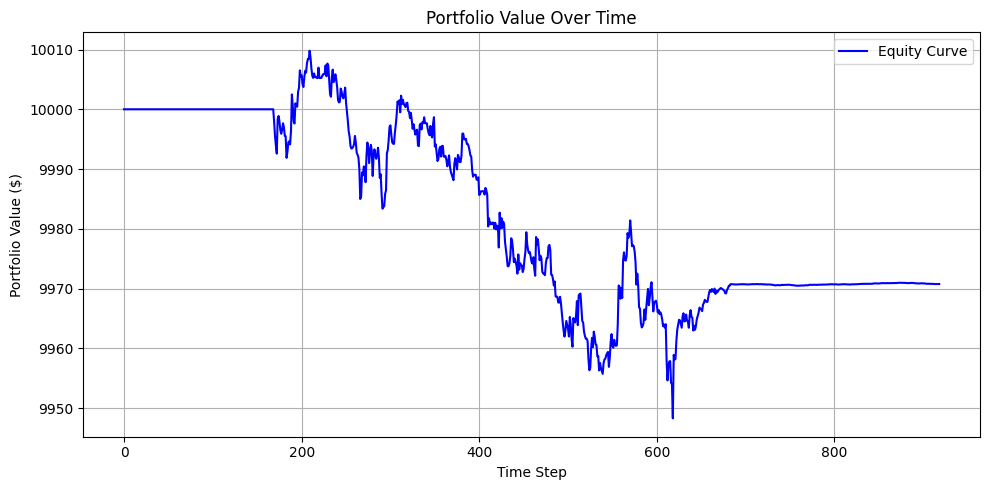

=== Test Report ===
Initial Balance : $10000.00
Final Value     : $9973.24
Total Profit    : $-26.76
Buy Trades      : 59
Sell Trades     : 0


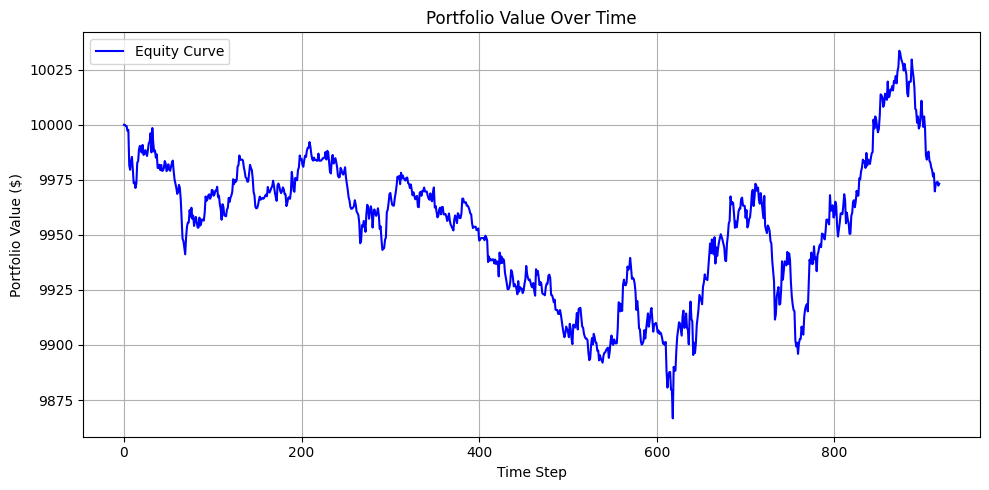

=== Test Report ===
Initial Balance : $10000.00
Final Value     : $10018.37
Total Profit    : $18.37
Buy Trades      : 6
Sell Trades     : 0


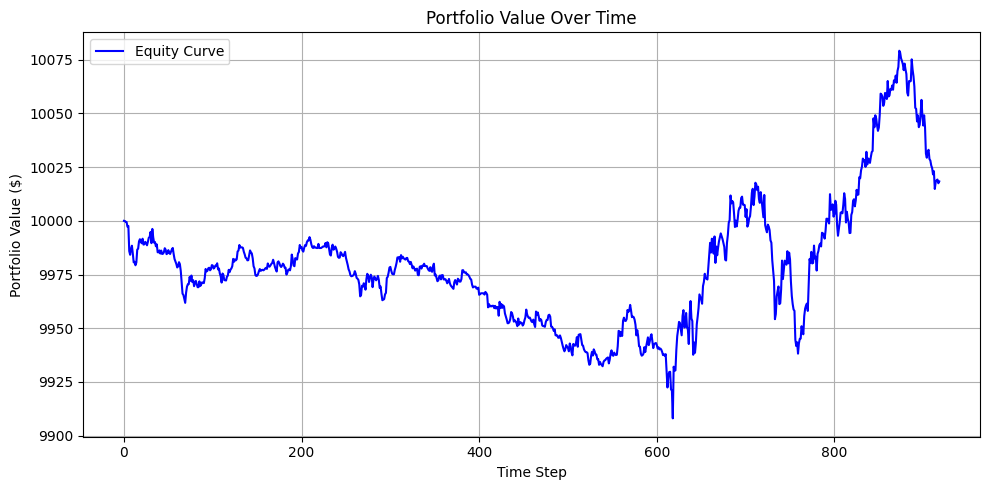

In [4]:
import numpy as np
import pandas as pd
import torch
from collections import deque
import matplotlib.pyplot as plt


def test_trading(csv_path, dqn_model_path, double_model_path, dueling_double_model_path, lstm_path):
    # 1. Load and preprocess test data
    processor = DataProcessor(csv_path)
    scaled_data, prices = processor.preprocess()
    X, y = processor.create_sequences(scaled_data, prices)

    # 2. Load trained LSTM predictor
    input_size = X.shape[2]
    lstm_model = LSTMPredictor(input_size).to(device)
    lstm_model.load_state_dict(torch.load(lstm_path))
    lstm_model.eval()

    # 3. Create grids and initialize environment
    grids = create_grids(prices)
    env = AdaptiveTradingEnvironment(
        data=scaled_data, 
        prices=prices,
        predictor=lstm_model, 
        initial_grids=grids
    )
    state = env.reset()

    # 4.1 Load trained Dueling DQN agent
    state_size = len(state)
    action_size = 3
    agent = DQNAgent(state_size, action_size)
    agent.model = DQN(state_size, action_size).to(device)
    agent.model.load_state_dict(torch.load(dqn_model_path))
    agent.model.eval()
    agent.epsilon = 0
    # 5. Run testing episode
    portfolio_values = []
    trades = []
    while not env.done:
        action = agent.act(state)
        next_state, reward, done, portfolio_value = env.step(action)
        state = next_state
        portfolio_values.append(portfolio_value)
        if action == 1:
            trades.append(('buy', env.prices[env.current_step]))
        elif action == 2:
            trades.append(('sell', env.prices[env.current_step]))

    # 6. Reporting
    final_value = portfolio_values[-1]
    profit = final_value - INITIAL_BALANCE
    buys = len([t for t in trades if t[0] == 'buy'])
    sells = len([t for t in trades if t[0] == 'sell'])

    print("=== Test Report ===")
    print(f"Initial Balance : ${INITIAL_BALANCE:.2f}")
    print(f"Final Value     : ${final_value:.2f}")
    print(f"Total Profit    : ${profit:.2f}")
    print(f"Buy Trades      : {buys}")
    print(f"Sell Trades     : {sells}")

    # 7. Plot equity curve
    plt.figure(figsize=(10, 5))
    plt.plot(portfolio_values, label="Equity Curve", color='blue')
    plt.title("Portfolio Value Over Time")
    plt.xlabel("Time Step")
    plt.ylabel("Portfolio Value ($)")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()
    
    state = env.reset()

    # 4.2 Load trained Dueling DQN agent
    state_size = len(state)
    action_size = 3
    agent = DoubleDQNAgent(state_size, action_size)
    agent.model = DQN(state_size, action_size).to(device)
    agent.model.load_state_dict(torch.load(double_model_path))
    agent.model.eval()
    agent.epsilon = 0
    # 5. Run testing episode
    portfolio_values = []
    trades = []
    while not env.done:
        action = agent.act(state)
        next_state, reward, done, portfolio_value = env.step(action)
        state = next_state
        portfolio_values.append(portfolio_value)
        if action == 1:
            trades.append(('buy', env.prices[env.current_step]))
        elif action == 2:
            trades.append(('sell', env.prices[env.current_step]))

    # 6. Reporting
    final_value = portfolio_values[-1]
    profit = final_value - INITIAL_BALANCE
    buys = len([t for t in trades if t[0] == 'buy'])
    sells = len([t for t in trades if t[0] == 'sell'])

    print("=== Test Report ===")
    print(f"Initial Balance : ${INITIAL_BALANCE:.2f}")
    print(f"Final Value     : ${final_value:.2f}")
    print(f"Total Profit    : ${profit:.2f}")
    print(f"Buy Trades      : {buys}")
    print(f"Sell Trades     : {sells}")

    # 7. Plot equity curve
    plt.figure(figsize=(10, 5))
    plt.plot(portfolio_values, label="Equity Curve", color='blue')
    plt.title("Portfolio Value Over Time")
    plt.xlabel("Time Step")
    plt.ylabel("Portfolio Value ($)")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()
    
    state = env.reset()
    # 4.3 Load trained Dueling DQN agent
    state_size = len(state)
    action_size = 3
    agent = DuelDoubleDQNAgent(state_size, action_size)
    agent.model = DuelingDQN(state_size, action_size).to(device)
    agent.model.load_state_dict(torch.load(dueling_double_model_path))
    agent.model.eval()
    agent.epsilon = 0
    # 5. Run testing episode
    portfolio_values = []
    trades = []
    while not env.done:
        action = agent.act(state)
        next_state, reward, done, portfolio_value = env.step(action)
        state = next_state
        portfolio_values.append(portfolio_value)
        if action == 1:
            trades.append(('buy', env.prices[env.current_step]))
        elif action == 2:
            trades.append(('sell', env.prices[env.current_step]))

    # 6. Reporting
    final_value = portfolio_values[-1]
    profit = final_value - INITIAL_BALANCE
    buys = len([t for t in trades if t[0] == 'buy'])
    sells = len([t for t in trades if t[0] == 'sell'])

    print("=== Test Report ===")
    print(f"Initial Balance : ${INITIAL_BALANCE:.2f}")
    print(f"Final Value     : ${final_value:.2f}")
    print(f"Total Profit    : ${profit:.2f}")
    print(f"Buy Trades      : {buys}")
    print(f"Sell Trades     : {sells}")

    # 7. Plot equity curve
    plt.figure(figsize=(10, 5))
    plt.plot(portfolio_values, label="Equity Curve", color='blue')
    plt.title("Portfolio Value Over Time")
    plt.xlabel("Time Step")
    plt.ylabel("Portfolio Value ($)")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()
# Example usage
if __name__ == "__main__":
    test_trading(
        csv_path="live_temp.csv",
        dqn_model_path = "dqn_agent_fixed_grid.pth",
        double_model_path="doubledqn_agent_fixed_grid.pth",
        dueling_double_model_path = "dueldoubledqn_agent_fixed_grid.pth",
        lstm_path="lstm_predictor_fixed_grid.pth"
    )
